In [19]:
import pandas as pd 
import numpy as np
import datetime
import calendar
import alphalens
import heapq
import matplotlib.dates as dt
import matplotlib.pyplot as plt
import time, datetime, calendar

# 设置matplotlib图像风格
#plt.style.use('fivethirtyeight')
#plt.rcParams['font.sans-serif']=['SimHei']

In [20]:
class BT:
    """
    输入：时间、历史数据、调仓（表格从上到下，时间从近到远）
    """
    

    def __init__(self,df_date,df_history,df_transfer,initial_asset=100):
        self.df_date=df_date
        self.initial_asset=initial_asset
        self.rf=0
        self.df_history=df_history
        self.df_transfer=df_transfer
        df1=pd.DataFrame({'asset':(np.array(self.df_history)*np.array(self.df_transfer)).sum(axis=1)
            ,'bool':(abs(self.df_transfer-self.df_transfer.shift(-1)).sum(axis=1)).apply(lambda x:x>0)})
        df2=(pd.DataFrame((np.array(self.df_history)*np.array(self.df_transfer))).sum(axis=1)/((pd.DataFrame(np.array(self.df_history)*np.array(self.df_transfer.shift(-1)))).fillna(1/self.df_history.shape[1]).sum(axis=1)))[df1['bool']]
        df2=((df2[::-1]).cumprod())[::-1]
        df2=pd.DataFrame(df2,columns=['times'])
        df1=pd.concat([df1,df2],axis=1)
        df1.iloc[-1,-1]=1
        df1['times']=df1['times'].fillna(method='bfill')
        df_asset=df1['asset']/(df1['times']*df1['asset'].iloc[-1])*self.initial_asset
        df_return=(df_asset-df_asset.shift(-1))/df_asset.shift(-1)
        self.df_asset=df_asset
        self.df_return = df_return
    
    
    def set_rf(self,rf):
        """
        设定无风险收益率
        """
        self.rf=rf
        

    
    def info(self):
        print("年化收益率：%.4f"%(self.annualized_return_rate())+"\n")
        print("年化波动率：%.4f"%(self.annualized_volatiliy())+"\n")
        print("夏普比率：%.4f"%((self.sharpe()))+"\n")
        print("最大回测：%.4f"%(self.max_drawdown())+"\n")
        print("胜率：%.4f"%(self.win())+"\n")
        return [self.annualized_return_rate(),self.annualized_volatiliy(),self.annualized_return_rate()/self.annualized_volatiliy(),self.max_drawdown(),self.win()]
        
    #回测指标
    
    #年化收益率
    def annualized_return_rate(self):
        df_asset=self.df_asset
        df_asset=np.hstack([df_asset,[100,100,100]])
        YR=((df_asset[::12]-df_asset[::-12][::-1])/df_asset[::12][::-1]).mean()
        return YR
        
    #年化波动率
    def annualized_volatiliy(self):
        df = self.df_return.dropna()
        YV = np.std(df)*np.sqrt(12)
        return YV
    
    #最大回测
    def max_drawdown(self):
        df = self.df_asset.dropna()
        md = ((df.cummin()-df)/df).min()
        return md
    
    #胜率
    def win(self):
        df = self.df_return.dropna()
        df_bool = df.apply(lambda x:x>0)
        w=df_bool.sum()/df.shape[0]
        return w
    
    #夏普比率
    def sharpe(self):
        df = self.df_return.dropna()
        sp = ((df.sum())/(df.shape[0]))/np.std(df)*np.sqrt(12)
        return sp
def Plot(date,data1,data2,title="",label1="",label2="",\
         save_path=False,figure_size=[18,6]):
    """
    对两份时间序列数据作图
    """
    year = dt.YearLocator()
    yearformat = dt.DateFormatter('%Y')
    fig=plt.figure(figsize=figure_size)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot_date(pd.to_datetime(date),data1,'-',\
                 linewidth = 2.5,label=label1, alpha=1)
    ax.plot_date(pd.to_datetime(date),data2,'-',\
                 linewidth = 2.5,label=label2, alpha=1)
    ax.xaxis.set_major_locator(year)
    #ax.yaxis.set_major_formatter(FuncFormatter(to_percent))
    ax.xaxis.set_major_formatter(yearformat)
    ax.legend(fontsize=16)
    ax.set_title(title,fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    if save_path:
        fig.savefig(save_path)         

In [21]:
df_long = pd.read_csv("../XGBoost/Out/Long_View.csv",index_col = 0).iloc[::-1,1:]
df_short = pd.read_csv("../XGBoost/Out/Short_View.csv",index_col = 0).iloc[::-1,1:]
df_history = pd.read_csv("../Data/XGBoost_Test.csv").iloc[::-1,0:6]
df_date =pd.to_datetime(df_history['Date'])
df_history.drop(['Date'],axis=1,inplace=True)
df_date.index = list(range(72))
df_long.index = list(range(72))
df_short.index= list(range(72))
df_history.index = list(range(72))
df_long = df_long.astype('float64')


bt_long = BT(df_date,(df_history),(df_long))
bt_short = BT(df_date,(df_history),(df_short))

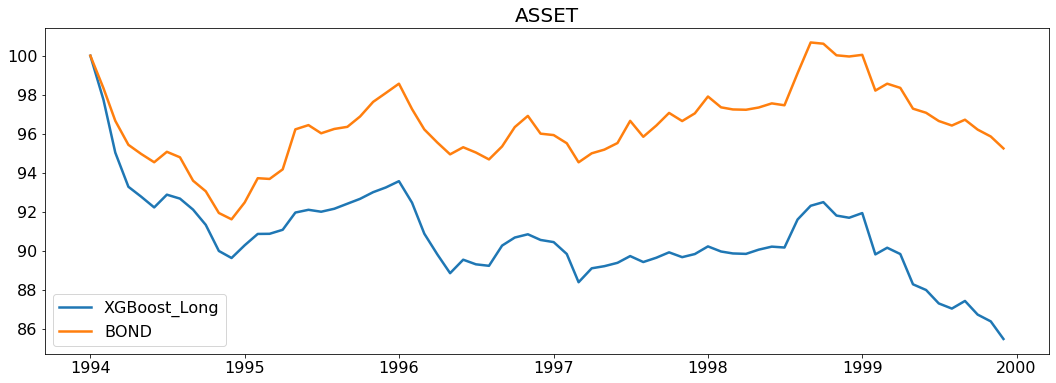

In [22]:
Plot(df_date,bt_long.df_asset,df_history.mean(axis=1)/df_history.mean(axis=1)[71]*100,"ASSET","XGBoost_Long","BOND")

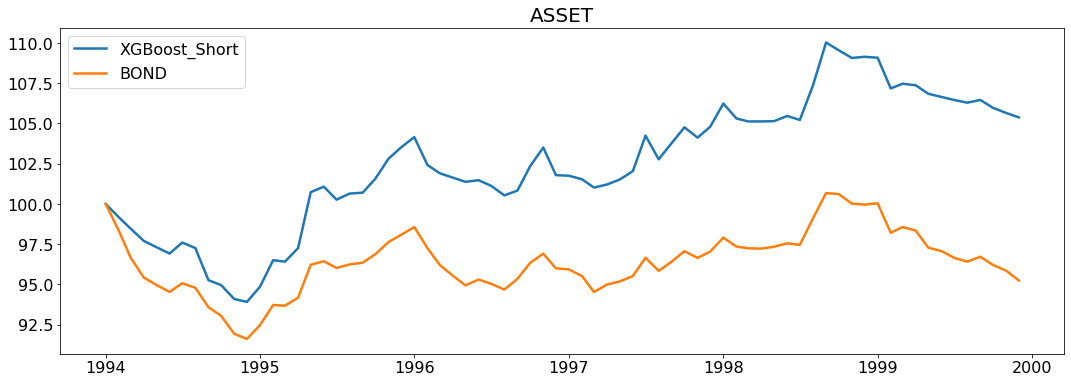

In [23]:
Plot(df_date,bt_short.df_asset,df_history.mean(axis=1)/df_history.mean(axis=1)[71]*100,"ASSET","XGBoost_Short","BOND")

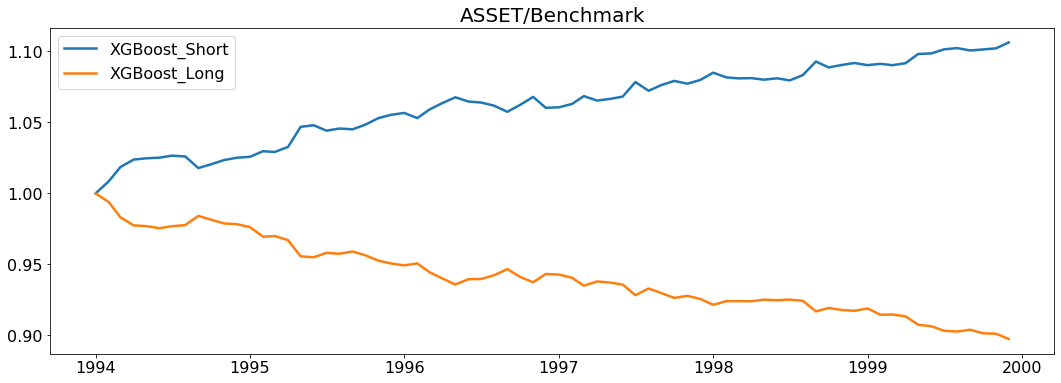

In [24]:
Plot(df_date,bt_short.df_asset/(df_history.mean(axis=1)/df_history.mean(axis=1)[71]*100),bt_long.df_asset/(df_history.mean(axis=1)/df_history.mean(axis=1)[71]*100),"ASSET/Benchmark","XGBoost_Short","XGBoost_Long")